In [1]:
from utils.dataset import  CustomDataset
import os
import warnings
warnings.filterwarnings("ignore")
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import sys
import pandas as pd
from tqdm import tqdm
import threading
import random
# import rasterio
import os
import numpy as np
import sys
from sklearn.utils import shuffle as shuffle_lists
import numpy as np
from sklearn.model_selection import train_test_split
import joblib

import torch

#default
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

#trasnform
from torchvision import transforms

#dataset
from utils.dataset import CustomDataset
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from torchsummary import summary
from torchsampler import ImbalancedDatasetSampler

#metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import torchmetrics.functional as tf

#numeric
import numpy as np
import pandas as pd 

#visualization
import matplotlib.pyplot as plt

#system 
from tqdm import tqdm
import os 
import wandb
import datetime


In [2]:
now = datetime.datetime.now()
formatted_now = now.strftime("%Y%m%d%H%M")
checkpoint_datetime = formatted_now
print(f"#"*30, "SAVE TIME", "#"*30)
print(f"#"*30, checkpoint_datetime, "#"*30)

############################## SAVE TIME ##############################
############################## 202403200237 ##############################


In [3]:
train_csv = '../../dataset/train_meta.csv'

train_transform = transforms.Compose([
    # transforms.Resize((512,512), antialias= True),
    # transforms.RandomApply([
    #     transforms.RandomRotation(degrees = 30),
    #     transforms.RandomVerticalFlip(p= 0.5),
    #     transforms.RandomVerticalFlip(p=0.5),
    #     transforms.RandomCrop(size =224, scale= (0.8, 1.2), ratio = (0.75, 1.2), antialias = True),
    #     transforms.ColorJitter(brightness= 0.2, contrast = 0.2)
    # ]),
    transforms.ToTensor()
])
tr_batch = 6
vl_batch = 1

dataset = CustomDataset(
    csv_path= train_csv,
    transform= None, #None으로 세팅
    MAX_PIXEL_VALUE= 65535,
    band = (7,6,2) #기존 세팅 
)

# 훈련 및 검증 세트 분할
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size 
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = tr_batch
    # sampler= ImbalancedDatasetSampler(train_dataset),
)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle= False)



torch.Size([6, 256, 256, 3])


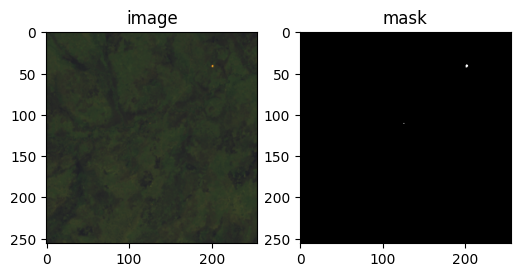

torch.Size([1, 256, 256, 3])


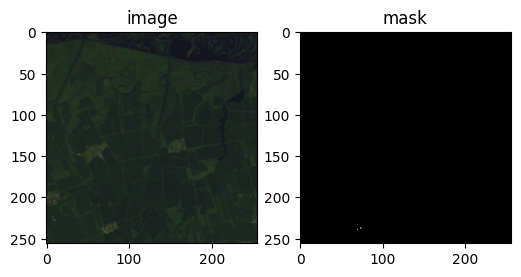

In [4]:
for images, masks in train_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

for images, masks in valid_loader:
    print(images.shape)
    idx = 0
    plt.figure(figsize=(6,4))
    plt.subplot(121)
    plt.imshow(images[idx])
    plt.title('image')
    plt.subplot(122)
    plt.imshow(masks[idx], cmap= 'gray')
    plt.title('mask')
    plt.show()
    break

In [5]:
import sys 
sys.path.append('../')
from network.models import get_pretrained_model
from torchsummary import summary

# if torch.cuda.is_available():
#     device = 'cuda'
#     torch.cuda.manual_seed_all(42)
device = 'cuda'
# # random seed 고정
# random.seed(42)
# if torch.cuda.is_available():
#     device = torch.device('cuda')
#     torch.cuda.manual_seed_all(42)
# else:
#     device = torch.device('cuda')
#     torch.manual_seed_all(42)

# # model & cost func & optimizer 정의
############################ V1~2 #############################
"""model = get_pretrained_model('unet').get()"""
############################ V3~4 #############################
# model = AttU_Net(img_ch= 3, output_ch= 1)
model = get_pretrained_model('attunet').get()
"""model = get_pretrained_model('r2attunet').get()"""
############################ V5 #############################
# model = get_pretrained_model('unet++').get()
############################ V6 #############################


model.to(device)

lr = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda= lambda epoch: 0.95**epoch)

loss = nn.BCELoss()

print(f'device : {device}')
# summary(model, input_size=(3, 224, 224))



Model name : attunet
device : cuda


In [6]:
metrics = {
    'tr_bce' : [],
    'vl_bce' : [],
    'tr_iou' : [],
    'vl_iou' : [],
}
epoch, epochs = 0, 200
early_stopping_epochs, early_stopping_cnt= 10, 0
SAVE_DIR = '../../satellite_model'
best_loss = float('inf')


In [7]:
def checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds):
    # loss plot
    plt.figure(figsize=(10, 7))
    plt.subplot(121)
    plt.plot(metrics['tr_bce'], label='Train Loss')
    plt.plot(metrics['vl_bce'], label='Valid Loss')
    plt.title("BCE | DOWN GOOD")
    plt.legend()
    plt.subplot(122)
    plt.plot(metrics['tr_iou'], label='Train IoU')
    plt.plot(metrics['vl_iou'], label='Valid IoU')
    plt.title("mIOU | UP GOOD")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_loss.png'))
    plt.close()
    
    # mask plot
    plt.figure(figsize=(10, 7))
    plt.subplot(131)
    plt.imshow(images[0].cpu().permute(1,2,0))
    plt.title('image')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(masks[0].cpu().permute(1,2,0))
    plt.title('mask')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(preds[0].cpu().permute(1,2,0))
    plt.title('pred')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}_mask.png'))
    plt.close()
    
    torch.save({
        "model" : f"{epoch}",
        "epoch" : epoch,
        "epochs" : epochs,
        "model_state_dict" : model.state_dict(),
        "optimizer_state_dict" : optimizer.state_dict(),
        "learning_rate" : lr,
        "loss" : loss,
        "metric" : metrics,
        "description" : f"segmentation model training status : {epoch}/{epochs}"
    },
    os.path.join(SAVE_DIR, checkpoint_datetime+f'_{epoch}_{epochs}.pt'))
    print(f"#"*30, f"SAVE PATH : {SAVE_DIR}", "#"*30)
    
def calculate_iou(preds, masks, threshold=0.5):
    # 예측 마스크를 이진 형태로 변환
    preds = (preds > threshold).float()
    
    intersection = torch.sum(preds * masks)
    union = torch.sum((preds + masks) > 0)
    
    iou = (intersection + 1e-7) / (union + 1e-7)  # 0으로 나누는 경우를 방지하기 위해 작은 값(1e-7)을 추가
    
    return iou

In [8]:
for epoch in tqdm(range(epoch, epochs), desc="Training Progress"):
    train_losses, valid_losses = 0., 0.
    train_ious, valid_ious = 0., 0.
    
    model.train()
    for _, (images, masks) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images, masks = images.to(device), masks.to(device)
        images = images.permute(0,3,1,2)
        masks = masks.permute(0,3,1,2)
        
        preds = model(images)
        train_loss = loss(preds, masks).to(device)
        train_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses += train_loss.item()
        train_ious += train_iou
        break 
    scheduler.step()
    
    metrics['tr_bce'].append(train_losses / len(train_loader))
    metrics['tr_iou'].append(train_ious / len(train_loader))
    print(f"Epoch : {epoch}/{epochs} | Train Loss : {train_losses / len(train_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Train IOU : {train_ious / len(train_loader)}")
    
    with torch.no_grad():
        model.eval()
        for _, (images, masks) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            images, masks = images.to(device), masks.to(device)
            images = images.permute(0,3,1,2)
            masks = masks.permute(0,3,1,2)

            preds = model(images)
            valid_loss = loss(preds, masks).to(device)
            valid_iou = calculate_iou(preds, masks).cpu().detach().numpy()
        
            valid_losses += valid_loss.item()
            valid_ious += valid_iou
            break
            

    metrics['vl_bce'].append(valid_losses / len(valid_loader))
    metrics['vl_iou'].append(valid_ious / len(valid_loader))
    print(f"Epoch : {epoch}/{epochs} | Valid Loss : {valid_losses / len(valid_loader)}")
    print(f"Epoch : {epoch}/{epochs} | Valid IOU : {valid_ious / len(valid_loader)}")

    # Early Stopping
    if valid_losses > best_loss:
        best_loss = valid_losses
        early_stopping_cnt = 0
    else:
        early_stopping_cnt += 1
        if early_stopping_cnt >= early_stopping_epochs:
            print(f"Early Stops!!! : {epoch}/{epochs}")
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    
    # Validation 성능이 이전보다 우수한 경우 모델 저장
    try:        
        if valid_losses > np.array(metrics['vl_bce'])[:-1].max() and epoch%10 == 0:
            pass
            # checkpoint(SAVE_DIR, checkpoint_datetime, model, optimizer, lr, loss, metrics, epoch, epochs, images, masks, preds)
    except Exception as e:
        print(e)
        pass

Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 0/200 | Train Loss : 0.00015075152969956797
Epoch : 0/200 | Train IOU : 1.973200700503123e-08


Training Progress:   0%|          | 1/200 [00:00<02:15,  1.47it/s]

Epoch : 0/200 | Valid Loss : 0.00011169811015864051
Epoch : 0/200 | Valid IOU : 6.817031599032018e-09
zero-size array to reduction operation maximum which has no identity


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 1/200 | Train Loss : 0.00014322968181126986
Epoch : 1/200 | Train IOU : 3.993394303574296e-08


Training Progress:   1%|          | 2/200 [00:00<01:22,  2.39it/s]

Epoch : 1/200 | Valid Loss : 0.00011208490569113975
Epoch : 1/200 | Valid IOU : 6.817031599032018e-09


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 2/200 | Train Loss : 0.00013541923667374322
Epoch : 2/200 | Train IOU : 5.4398602029062794e-08


Training Progress:   2%|▏         | 3/200 [00:01<01:05,  3.03it/s]

Epoch : 2/200 | Valid Loss : 0.00011217311879013868
Epoch : 2/200 | Valid IOU : 6.817031599032018e-09


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 3/200 | Train Loss : 0.00012736472802314476
Epoch : 3/200 | Train IOU : 8.831833308674553e-08


Training Progress:   2%|▏         | 4/200 [00:01<00:56,  3.45it/s]

Epoch : 3/200 | Valid Loss : 0.00011199058566800002
Epoch : 3/200 | Valid IOU : 6.817031599032018e-09


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 4/200 | Train Loss : 0.00012114800484499443
Epoch : 4/200 | Train IOU : 1.3714012244093464e-07


Training Progress:   2%|▎         | 5/200 [00:01<00:53,  3.62it/s]

Epoch : 4/200 | Valid Loss : 0.00011170148316906711
Epoch : 4/200 | Valid IOU : 6.817031599032018e-09


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 5/200 | Train Loss : 0.00011559947409852424
Epoch : 5/200 | Train IOU : 1.414789789520006e-07


Training Progress:   3%|▎         | 6/200 [00:01<00:50,  3.84it/s]

Epoch : 5/200 | Valid Loss : 0.00011134538203144997
Epoch : 5/200 | Valid IOU : 6.817031599032018e-09


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 6/200 | Train Loss : 0.00011110130047622418
Epoch : 6/200 | Train IOU : 1.4627626792315344e-07


Training Progress:   4%|▎         | 7/200 [00:02<00:48,  4.01it/s]

Epoch : 6/200 | Valid Loss : 0.00011093896978041705
Epoch : 6/200 | Valid IOU : 6.817031599032018e-09


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 7/200 | Train Loss : 0.00010746893191513325
Epoch : 7/200 | Train IOU : 1.8245700321574015e-07


Training Progress:   4%|▍         | 8/200 [00:02<00:46,  4.16it/s]

Epoch : 7/200 | Valid Loss : 0.00011052155974012476
Epoch : 7/200 | Valid IOU : 6.817031599032018e-09


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 8/200 | Train Loss : 0.00010427878535110715
Epoch : 8/200 | Train IOU : 1.3550891677616216e-07


Training Progress:   4%|▍         | 9/200 [00:02<00:46,  4.14it/s]

Epoch : 8/200 | Valid Loss : 0.00011008444421786651
Epoch : 8/200 | Valid IOU : 6.817031599032018e-09


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 9/200 | Train Loss : 0.00010153722464838597
Epoch : 9/200 | Train IOU : 2.5097063147837974e-07


Training Progress:   5%|▌         | 10/200 [00:02<00:45,  4.21it/s]

Epoch : 9/200 | Valid Loss : 0.00010966837450540163
Epoch : 9/200 | Valid IOU : 6.817031599032018e-09
Early Stops!!! : 9/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 10/200 | Train Loss : 9.913270910696337e-05
Epoch : 10/200 | Train IOU : 2.868788425850368e-07


Training Progress:   6%|▌         | 11/200 [00:03<00:44,  4.21it/s]

Epoch : 10/200 | Valid Loss : 0.00010935045939635095
Epoch : 10/200 | Valid IOU : 6.817031599032018e-09
Early Stops!!! : 10/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 11/200 | Train Loss : 9.701715693666596e-05
Epoch : 11/200 | Train IOU : 2.683855263278744e-07


Training Progress:   6%|▌         | 12/200 [00:03<00:44,  4.23it/s]

Epoch : 11/200 | Valid Loss : 0.00010877177507595083
Epoch : 11/200 | Valid IOU : 6.817031599032018e-09
Early Stops!!! : 11/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 12/200 | Train Loss : 9.51397903588086e-05
Epoch : 12/200 | Train IOU : 3.116342734386539e-07


Training Progress:   6%|▋         | 13/200 [00:03<00:44,  4.18it/s]

Epoch : 12/200 | Valid Loss : 0.00010816225433917696
Epoch : 12/200 | Valid IOU : 6.817031599032018e-09
Early Stops!!! : 12/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 13/200 | Train Loss : 9.346022945657116e-05
Epoch : 13/200 | Train IOU : 4.2888605898516186e-07


Training Progress:   7%|▋         | 14/200 [00:03<00:44,  4.16it/s]

Epoch : 13/200 | Valid Loss : 0.00010747588222273587
Epoch : 13/200 | Valid IOU : 6.817031599032018e-09
Early Stops!!! : 13/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 14/200 | Train Loss : 9.193908617063535e-05
Epoch : 14/200 | Train IOU : 5.605115613681492e-07


Training Progress:   8%|▊         | 15/200 [00:03<00:43,  4.23it/s]

Epoch : 14/200 | Valid Loss : 0.00010669613985188045
Epoch : 14/200 | Valid IOU : 6.817031599032018e-09
Early Stops!!! : 14/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 15/200 | Train Loss : 9.054910771836652e-05
Epoch : 15/200 | Train IOU : 5.9247707129723e-07


Training Progress:   8%|▊         | 16/200 [00:04<00:43,  4.24it/s]

Epoch : 15/200 | Valid Loss : 0.00010570219356624918
Epoch : 15/200 | Valid IOU : 6.817031599032018e-09
Early Stops!!! : 15/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 16/200 | Train Loss : 8.927718693586447e-05
Epoch : 16/200 | Train IOU : 7.231947577955575e-07


Training Progress:   8%|▊         | 17/200 [00:04<00:42,  4.28it/s]

Epoch : 16/200 | Valid Loss : 0.00010441789321728989
Epoch : 16/200 | Valid IOU : 6.84345042234535e-09
Early Stops!!! : 16/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 17/200 | Train Loss : 8.812002872605928e-05
Epoch : 17/200 | Train IOU : 7.664446230342885e-07


Training Progress:   9%|▉         | 18/200 [00:04<00:43,  4.23it/s]

Epoch : 17/200 | Valid Loss : 0.00010304703076917203
Epoch : 17/200 | Valid IOU : 1.7515919318634876e-08
Early Stops!!! : 17/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 18/200 | Train Loss : 8.70735192101849e-05
Epoch : 18/200 | Train IOU : 8.02230386128776e-07


Training Progress:  10%|▉         | 19/200 [00:04<00:42,  4.25it/s]

Epoch : 18/200 | Valid Loss : 0.0001011444753617026
Epoch : 18/200 | Valid IOU : 5.479041043981081e-15
Early Stops!!! : 18/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 19/200 | Train Loss : 8.611956530978484e-05
Epoch : 19/200 | Train IOU : 8.392630439099387e-07


Training Progress:  10%|█         | 20/200 [00:05<00:42,  4.21it/s]

Epoch : 19/200 | Valid Loss : 9.885423678741114e-05
Epoch : 19/200 | Valid IOU : 7.260864264431468e-15
Early Stops!!! : 19/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 20/200 | Train Loss : 8.525037861360299e-05
Epoch : 20/200 | Train IOU : 8.823629239853243e-07


Training Progress:  10%|█         | 21/200 [00:05<00:42,  4.19it/s]

Epoch : 20/200 | Valid Loss : 9.649444318758581e-05
Epoch : 20/200 | Valid IOU : 9.307520213310392e-15
Early Stops!!! : 20/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 21/200 | Train Loss : 8.445797766429228e-05
Epoch : 21/200 | Train IOU : 1.070647662089876e-06


Training Progress:  11%|█         | 22/200 [00:05<00:42,  4.22it/s]

Epoch : 21/200 | Valid Loss : 9.41005644297653e-05
Epoch : 21/200 | Valid IOU : 1.4319262661510106e-14
Early Stops!!! : 21/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 22/200 | Train Loss : 8.373251711121355e-05
Epoch : 22/200 | Train IOU : 1.2635291022116887e-06


Training Progress:  12%|█▏        | 23/200 [00:05<00:42,  4.21it/s]

Epoch : 22/200 | Valid Loss : 9.183360850376064e-05
Epoch : 22/200 | Valid IOU : 2.4655682889565746e-14
Early Stops!!! : 22/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 23/200 | Train Loss : 8.306377882506928e-05
Epoch : 23/200 | Train IOU : 1.3121898226341766e-06


Training Progress:  12%|█▏        | 24/200 [00:06<00:41,  4.27it/s]

Epoch : 23/200 | Valid Loss : 8.962161489502317e-05
Epoch : 23/200 | Valid IOU : 5.0141524092366005e-14
Early Stops!!! : 23/200


  0%|          | 0/4477 [00:00<?, ?it/s]


Epoch : 24/200 | Train Loss : 8.244403430545919e-05
Epoch : 24/200 | Train IOU : 1.374077008609024e-06


Training Progress:  12%|█▎        | 25/200 [00:06<00:40,  4.28it/s]

Epoch : 24/200 | Valid Loss : 8.75191997434342e-05
Epoch : 24/200 | Valid IOU : 5.598508750164705e-14
Early Stops!!! : 24/200


Training Progress:  12%|█▎        | 25/200 [00:06<00:44,  3.91it/s]


KeyboardInterrupt: 